In [1]:
import codeforces
import numpy as np
from keras.preprocessing import sequence

# fix random seed for reproducibility
np.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 2000
(X_train, y_train), (X_test, y_test) = codeforces.load_data(path='../codeforces_full.pkl',num_words=top_words)
# truncate and pad input sequences
max_review_length = 1000
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
print('block success')


block


Using TensorFlow backend.


block success


In [7]:
def split_by_cate(x , y):
    pos_data=[]
    neg_data=[]
    for i in range(len(y)):
        if(y[i]==1):
            pos_data.append(x[i])
        else:
            neg_data.append(x[i])
    return pos_data, neg_data
# folder generate: 处理数据不均衡问题
def fold_generator(x_train, x_test, y_train, y_test, shuffle):
    pos_data=[]
    neg_data=[]
    pos_data[0:0], neg_data[0:0] = split_by_cate(x_train, y_train)
    pos_data[0:0], neg_data[0:0] = split_by_cate(x_test, y_test)
            
    pos_data = np.asarray(pos_data)
    neg_data = np.asarray(neg_data)
    pos_sample_index = np.arange(len(pos_data))
    neg_sample_index = np.arange(len(neg_data))
    if shuffle:
        np.random.shuffle(pos_sample_index)
        np.random.shuffle(neg_sample_index)
    fold_size = len(neg_data)
    fold_num = len(pos_data)//len(neg_data)
    counter=0
    while True:
        #先从正样例取出和负样例等量数据
        pos_fold_index = pos_sample_index[fold_size*counter:fold_size*(counter+1)]
        neg_fold_index = neg_sample_index
        x_pos_fold = pos_data[pos_fold_index,]
        x_neg_fold = neg_data[neg_fold_index, ]
        
        x_fold= np.row_stack([x_pos_fold, x_neg_fold])
        y_fold=np.ones(fold_size*2, dtype=np.int16)
        y_fold[fold_size:2*fold_size]=0
        
        fold_index = np.arange(fold_size*2)
        np.random.shuffle(fold_index)
        
        data_num = 2*fold_size
        train_num = round(data_num*0.8)
        xtr = x_fold[fold_index[0:train_num]]
        ytr = y_fold[fold_index[0:train_num]]
        xte = x_fold[fold_index[train_num:data_num]]
        yte = y_fold[fold_index[train_num:data_num]]
        counter +=1
        yield xtr,ytr,xte,yte
        if (counter == fold_num):
            if shuffle:
                np.random.shuffle(pos_sample_index)
                np.random.shuffle(neg_sample_index)
            counter = 0
        
        
    
## Batch generators ##################################################################################################################################

def batch_generator(X, y, batch_size, shuffle):
    #chenglong code for fiting from generator (https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22567/neural-network-for-sparse-matrices)
    number_of_batches =len(X)//batch_size
    counter = 0
    sample_index = np.arange(len(X))
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:]
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = len(X)//batch_size
    counter = 0
    sample_index = np.arange(len(X))
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :]
        counter += 1
        yield X_batch
        if (counter == number_of_batches):
            counter = 0
print('block success')

block success


In [8]:
# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

def seq_cla_nn_model():
    #LSTM and CNN for sequence classification model
    # create the model
    embedding_vecor_length = 200
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
    model.add(Conv1D(padding="same", kernel_size=3,activation='relu',filters=64))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(200))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
print('block success')

block success


In [ ]:
def concate(val, te):
    if val == None:
        val = te
    else:
        val = np.concatenate((val,te),axis=0)
    return val

def createBaggingModels(subModelCount):
    """Helper function to create a dictionary of submodels for use in the bagging training"""
    bagModels = {}
    for i in range(subModelCount):
        name = "model_%d"%(i)
        bagModels[name] = seq_cla_nn_model()
        if i==0:
            print(bagModels[name].summary())
        print("%s create success!"%(name))
    return bagModels

def BaggingAverage(xval,models, verbose = False):
    """Average the probabilities for a given test sample across models to finalize the prediction""" 
    results = []
    for _,model in models.items():
        result = model.predict(xval)
        results.append(result)
    results = np.column_stack(results)
    results = np.mean(results, axis=1)
    return results

def BaggingVote(xval, models, verbose = False):
    """Vote based on the probabilities for a given test sample across models to finalize the prediction"""
    result = [np.round(model.predict(xval)) for _, model in models.items()]
    result = np.column_stack(result)
    result = np.round(np.mean(result,axis=1))
    return result

subModelCount = 1
models = createBaggingModels(subModelCount)

# Train all the models
nepochs=10
toTrain = models.keys() 
data_generate = fold_generator(X_train, X_test, y_train, y_test, shuffle=True)

xval = None
yval = None
print('Train model begin:')
for k in toTrain: 
    print("Training model: " + k)
    xtr,ytr,xte,yte = next(data_generate)
    
    models[k].fit_generator(generator = batch_generator(xtr, ytr, 64, True),
                            verbose = 1,
                            steps_per_epoch = len(xtr)//64,
                            epochs = nepochs,
                              )
    scores = models[k].evaluate(xte, yte, verbose=0)
    print("mode %s Accuracy: %.2f%%" % (k, scores[1]*100))
    xval = concate(xval, xte)
    yval = concate(yval, yte)
   
    models[k].save_weights("model-" + k + ".hdf5", overwrite=True)
# test bagging

ave_pred = BaggingAverage(xval, models, verbose = False)
vote_pred = BaggingVote(xval, models, verbose = False)
print('block success!')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 200)         400000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 64)          38464     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 500, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               212000    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 650,665.0
Trainable params: 650,665.0
Non-trainable params: 0.0
_________________________________________________________________
None
model_0 create success!
Train model begin:
Training model: model_0
Epoch 1/10
  4/289 [..............................] - ETA:

(0.67571533382245053, 0.78684322938914997, 0.7270574304322085, None)
(0.67571533382245053, 0.78684322938914997, 0.7270574304322085, None)


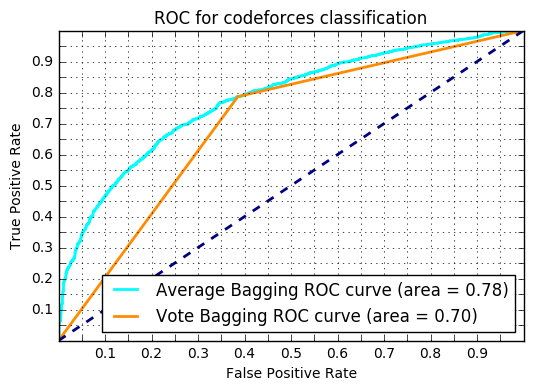

In [9]:
from sklearn.metrics import precision_recall_fscore_support

ave_result = precision_recall_fscore_support(yval, np.round(ave_pred), average='binary')
vote_result = precision_recall_fscore_support(yval, np.round(vote_pred), average='binary')
print(ave_result)
print(vote_result)
#ROC曲线和AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr={}
tpr={}
roc_auc={}

y_score1 = ave_pred
y_score2 = vote_pred

fpr['ave'], tpr['ave'], _ = roc_curve(yval, y_score1)
roc_auc['ave'] = auc(fpr['ave'], tpr['ave'])
fpr['vote'], tpr['vote'], _ = roc_curve(yval, y_score2)
roc_auc['vote'] = auc(fpr['vote'], tpr['vote'])
    
plt.figure()
lw = 2
plt.plot(fpr['ave'], tpr['ave'], color='aqua',
         lw=lw, label='Average Bagging ROC curve (area = %0.2f)' % roc_auc['ave'])
plt.plot(fpr['vote'], tpr['vote'], color='darkorange',
         lw=lw, label='Vote Bagging ROC curve (area = %0.2f)' % roc_auc['vote'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

tick_nb = 20
ticks = [x/tick_nb for x in range(1, tick_nb)]
labels = ['%.1f'%tick if tick*10%1==0 else '' for tick in ticks]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for codeforces classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()